In [ ]:
# import autoreload
# %load_ext autoreload
# %aimport Trainer
# %autoreload 1

In [3]:
import pandas as pd
from importlib import reload

## Configs

In [4]:
BATCH_SIZE = 32

## Preprocessing
Negative Sampling the dataset

In [5]:
# from src.Preprocess.Preprocessor import Preprocessor
# Preprocessor.create_negative_sampled_dataset(input_address="../data/SA_history_clicks_of_98.csv", 
#                                                output_address="../data/data1.pkl", 
#                                                neg_to_pos_ratio=1)

## DatasetHandler
Preparing dataset for training

In [8]:
from src.Trainer.DatasetHandler import DatasetHandler

# dataset_handler = DatasetHandler("data/SA_history_clicks_of_98.csv")
dataset_handler = DatasetHandler("data/small1.pkl")
# dataset_handler = DatasetHandler("data/data1.pkl")

Loading tokenizer...
Reading input file...



Creating dataset...



Done


In [9]:
import pandas as pd
# dataset_handler.df.loc[dataset_handler.df["similar"] == 0]
print(dataset_handler.get_dataset())
dataset_handler.df
pd.DataFrame(dataset_handler.get_dataset()["train"][:1000])

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'attention_mask', 'input_ids', 'packageName', 'package_ids', 'queryText', 'similar', 'token_type_ids'],
        num_rows: 17516
    })
    test: Dataset({
        features: ['__index_level_0__', 'attention_mask', 'input_ids', 'packageName', 'package_ids', 'queryText', 'similar', 'token_type_ids'],
        num_rows: 4380
    })
})


,__index_level_0__,attention_mask,input_ids,packageName,package_ids,queryText,similar,token_type_ids
0,5655,"[1, 1, 1, 1, 0, 0, 0, 0]","[2, 92219, 23854, 4, 0, 0, 0, 0]",bazyabi.ramz.wifi110,[24665],wpsapp,1,"[0, 0, 0, 0, 0, 0, 0, 0]"
1,12354,"[1, 1, 1, 1, 0, 0, 0, 0]","[2, 4143, 1174, 4, 0, 0, 0, 0]",com.takteam2.taketweety,[18246],قست,-1,"[0, 0, 0, 0, 0, 0, 0, 0]"
2,1077,"[1, 1, 1, 0, 0, 0, 0, 0]","[2, 17066, 4, 0, 0, 0, 0, 0]",persian.gulf.appmaker,[12671],ورد,-1,"[0, 0, 0, 0, 0, 0, 0, 0]"
3,12797,"[1, 1, 1, 1, 1, 0, 0, 0]","[2, 32605, 9549, 1154, 4, 0, 0, 0]",com.shilashila.daynasorshekamoo,[2409],دایناسور شکمو,1,"[0, 0, 0, 0, 0, 0, 0, 0]"
4,2484,"[1, 1, 1, 1, 1, 1, 1, 0]","[2, 8625, 4572, 60923, 2560, 12014, 4, 0]",com.abtination.tafavoth2aropeydakon,[17934],پیامک های جیگر خان عاشقانه,-1,"[0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
995,3648,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 8212, 5256, 20543, 4, 0, 0, 0, 0, 0, 0, 0,...",org.baatryy.plus.free,[24212],رمان قلب یخی,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
996,8113,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]","[2, 11547, 8964, 53629, 45760, 1192, 43775, 36...",air.WomenFitness,[51300],اجر شکن bricks breaker,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
997,1052,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 3701, 7456, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",com.myirancell.pezhiee,[18953],بسته حمایتی,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
998,17528,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 23541, 99754, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0...",com.persiagraph.comic_halo_escalationpart17en,[7387],allshare,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Training

Train on 17516 samples, test on 4380 samples
B
----------------



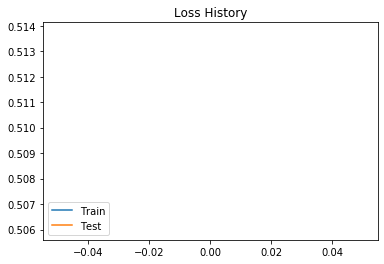

----------------



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Mohsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-64c6eb74787b>", line 9, in <module>
    trainer.train(epochs=50)
  File "F:\Programming\DNN\Tapsell\Task\sponsored-search\src\Trainer\Trainer.py", line 54, in train
    running_loss += loss.item()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Mohsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Mohsen\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _f

KeyboardInterrupt: 

In [61]:
import src.Trainer.RepresentationBuilder
reload(src.Trainer.RepresentationBuilder)
import src.Trainer.QueryAdCoordinator
reload(src.Trainer.QueryAdCoordinator)
import src.Trainer.Trainer
reload(src.Trainer.Trainer)

trainer = src.Trainer.Trainer.Trainer(embedding_dim=100, dataset_handler=dataset_handler)
trainer.train(epochs=50)

In [62]:
trainer.query_ad_coordinator

QueryAdCoordinator(
  (query_representation_builder): RepresentationBuilder(
    (embedding): Embedding(100000, 100)
    (pooling_module): SpanPoolingAvg()
  )
  (ad_representation_builder): RepresentationBuilder(
    (embedding): Embedding(72324, 100)
    (pooling_module): SpanPoolingAvg()
  )
  (loss): CosineEmbeddingLoss()
)

In [63]:
trainer.save_model()

Model save at QueryAdCoordinator_checkpoint.pt


In [64]:
trainer.save_all_ad_representations()


torch.Size([72324, 100])
Saved ad representations at representations/ad_reprs.pt
